# 모델링

- 파생변수 목록
    - CreditScoreByAge
    - TenureByAge
    - Engagement
    - CreditScoreByBalance
    - NumOfProductsByBalance
    - age_group
    - Balance_group
    - Balance_group_Geography
    - Age_Geography

- 최종 모델
    - Soft Voting
        - CatBoost, LightGBM, XGBoost,AdaBoost, GBC : 0.8920

## 패키지 설치 및 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install joblib==1.3
!pip install -q pycaret
!pip install -q catboost
!pip install --upgrade -q xgboost
!pip install bayesian-optimization==1.4.2

In [ ]:
# 기본 패키지
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리 (원핫은 pd.dummies로 이용)
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

# 데이터 분리
from sklearn.model_selection import train_test_split, GridSearchCV

# 모델 선택 도움, 하이퍼 파라미터
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from bayes_opt import BayesianOptimization

# catboost
import pycaret
from pycaret.classification import *
import catboost
from catboost import CatBoostClassifier

# LightGBM
from lightgbm import LGBMClassifier
# 앙상블
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,VotingClassifier

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier

# 모델 평가, 점수
from sklearn.metrics import roc_auc_score, roc_curve

# 변수 중요도
from sklearn.inspection import permutation_importance

## 전처리

In [ ]:
# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/테크잇 /9. 파이널 프로젝트 - 12/bank/train.csv')
test = pd.read_csv('/content/drive/MyDrive/테크잇 /9. 파이널 프로젝트 - 12/bank/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/테크잇 /9. 파이널 프로젝트 - 12/bank/sample_submission.csv')

# 변수 제거 : id, CustomerId, Surname
columns_to_drop = ['id', 'CustomerId', 'Surname']
train.drop(columns=columns_to_drop, inplace=True)
test.drop(columns=columns_to_drop, inplace=True)

# 중복 제거(전체 중복)
train = train.drop_duplicates()

# 타입 변경
## float -> int
train[['HasCrCard','IsActiveMember']] = train[['HasCrCard','IsActiveMember']].astype(int)
test[['HasCrCard','IsActiveMember']] = test[['HasCrCard','IsActiveMember']].astype(int)

## Encoding(Object -> int)
train = pd.get_dummies(train, columns=['Gender'],dtype=int)
test = pd.get_dummies(test, columns=['Gender'],dtype=int)

train['Geography'] = train['Geography'].str.replace('France', '1').str.replace('Germany', '2').str.replace('Spain', '3').astype(int)
test['Geography'] = test['Geography'].str.replace('France', '1').str.replace('Germany', '2').str.replace('Spain', '3').astype(int)


## float -> int(소수점 제거)
train['Age'] = (train['Age'] *10).astype(int)
train['Balance'] = round(train['Balance']).astype(int)
train['EstimatedSalary'] = (train['EstimatedSalary']*100).astype(int)

test['Age'] = (test['Age'] *10).astype(int)
test['Balance'] = round(test['Balance']).astype(int)
test['EstimatedSalary'] = (test['EstimatedSalary']*100).astype(int)

# 파생변수 생성

## 연령 별 신용점수
train['CreditScoreByAge'] = train.groupby('Age')['CreditScore'].transform('mean')
test['CreditScoreByAge'] = test.groupby('Age')['CreditScore'].transform('mean')

## 연령 별 은행사용기간
train['TenureByAge'] = train.groupby('Age')['Tenure'].transform('mean')
test['TenureByAge'] = test.groupby('Age')['Tenure'].transform('mean')

## 참여도
train['Engagement'] = train['NumOfProducts'] + train['HasCrCard'] + train['IsActiveMember']
test['Engagement'] = test['NumOfProducts'] + test['HasCrCard'] + test['IsActiveMember']

## 잔고 별 신용점수
train['CreditScoreByBalance'] = train.groupby('Balance')['CreditScore'].transform('mean')
test['CreditScoreByBalance'] = test.groupby('Balance')['CreditScore'].transform('mean')

## 잔고 별 상품 수
train['NumOfProductsByBalance'] = train.groupby('Balance')['NumOfProducts'].transform('mean')
test['NumOfProductsByBalance'] = test.groupby('Balance')['NumOfProducts'].transform('mean')

## age_group
train['age_group'] = pd.cut(train['Age'], bins=[150, 300, 400, 500, 1000],
                         labels=['20', '30', '40','50'],right=False)
test['age_group'] = pd.cut(test['Age'], bins=[150, 300, 400, 500, 1000],
                         labels=['20', '30', '40', '50'],right=False)

### age_gruop type 변경
train['age_group'] = train['age_group'].astype(int)
test['age_group'] = test['age_group'].astype(int)


## Balance_group
train['Balance_group'] = train['Balance'].map(lambda x:0 if x==0 else 1)
test['Balance_group'] = test['Balance'].map(lambda x:0 if x==0 else 1)

## Balance_group + Geography
train['Balance_group_Geography'] = train['Balance_group'] + train['Geography']
test['Balance_group_Geography'] = test['Balance_group'] + test['Geography']

## Age + Geography
train['Age_Geography'] = train['Age'] + train['Geography']
test['Age_Geography'] = test['Age'] + test['Geography']


# 스케일링
## Standard - Balance,TenureByAge,CreditScoreByBalance,Engagement,NumOfProductsByBalance
scaler_Standard = StandardScaler()

train[['Balance','TenureByAge','CreditScoreByBalance','Engagement','NumOfProductsByBalance']] = scaler_Standard.fit_transform(train[['Balance','TenureByAge','Engagement','CreditScoreByBalance','NumOfProductsByBalance']])
test[['Balance','TenureByAge','CreditScoreByBalance','Engagement','NumOfProductsByBalance']] = scaler_Standard.fit_transform(test[['Balance','TenureByAge','Engagement','CreditScoreByBalance','NumOfProductsByBalance']])

## Robust - CreditScore,Age,Age_Geography'
scaler_Robust = RobustScaler()
train[['CreditScore','Age','Age_Geography']] = scaler_Robust.fit_transform(train[['CreditScore','Age','Age_Geography']])
test[['CreditScore','Age','Age_Geography']] = scaler_Robust.fit_transform(test[['CreditScore','Age','Age_Geography']])

## MinMax - Tenure,EstimatedSalary
scaler_MinMax = MinMaxScaler()
train[['Tenure','EstimatedSalary']] = scaler_MinMax.fit_transform(train[['Tenure','EstimatedSalary']])
test[['Tenure','EstimatedSalary']] = scaler_MinMax.fit_transform(test[['Tenure','EstimatedSalary']])

# X, Y 분리
train_final_feature = train.loc[:, train.columns != 'Exited']
train_final_target = train['Exited']

# 데이터 분리
X_train, X_valid, y_train,y_valid = train_test_split(train_final_feature, train_final_target,
                                                     test_size=0.17,
                                                     stratify=train_final_target,
                                                     random_state=42)

### lightgbm - 0.8903

In [ ]:
# 하이퍼파라미터 구성 -> 범위 지정
param_bounds_LGB = {
    'n_estimators'      : (50, 500),               # 트리의 개수
    'learning_rate'     : (0.01, 0.3),             # 학습률
    'num_leaves'        : (20, 100),               # 각 트리의 최대 잎의 수
    'max_depth'         : (3, 10),                 # 각 트리의 최대 깊이
    'min_child_samples' : (10, 50),                # 리프 노드가 되기 위한 최소 샘플 수
    'subsample'         : (0.5, 1.0),              # 데이터 샘플링 비율
    'colsample_bytree'  : (0.5, 1.0),              # 트리를 구성할 때 feature를 선택하는 비율
    'reg_alpha'         : (0.0, 1.0),              # L1 regularization term
    'reg_lambda'        : (0.0, 1.0),              # L2 regularization term
    'min_child_weight'  : (0.1, 10.0),             # 각 잎의 최소 가중치 합
}

In [ ]:
def my_func_lgb(n_estimators, learning_rate,num_leaves,max_depth,min_child_samples,subsample,colsample_bytree,reg_alpha,reg_lambda,min_child_weight) :
  model_lgb = LGBMClassifier(
        n_estimators      =int(n_estimators),
        max_depth         =int(max_depth),
        num_leaves        =int(num_leaves),
        learning_rate     =float(learning_rate),
        min_child_samples =int(min_child_samples),
        subsample         =float(subsample),
        colsample_bytree  =float(colsample_bytree),
        reg_alpha         =float(reg_alpha),
        reg_lambda        =float(reg_lambda),
        min_child_weight  =float(min_child_weight),
        random_seed=42
    )

  model_lgb.fit(X_train, y_train)                             # 학습
  y_valid_preds = model_lgb.predict_proba(X_valid)[:, 1]      # 예측 및 평가
  roc_auc = roc_auc_score(y_valid, y_valid_preds)             # 검증 데이터 ROC AUC

  return roc_auc

optimizer_lgb = BayesianOptimization(my_func_lgb, param_bounds_LGB, random_state=42)

In [ ]:
optimizer_lgb.maximize(init_points=10, n_iter=100, acq='ei', xi=0.01)

In [ ]:
optimizer_lgb.max

{'target': 0.8915546298442032,
 'params': {'colsample_bytree': 0.7149607426850755,
  'learning_rate': 0.1320505358607961,
  'max_depth': 3.208210171440092,
  'min_child_samples': 32.98920320487443,
  'min_child_weight': 9.926182159641549,
  'n_estimators': 494.6024060956422,
  'num_leaves': 92.10939975600864,
  'reg_alpha': 0.2587367920678867,
  'reg_lambda': 0.19454548804683658,
  'subsample': 0.6450371549150287}}

In [ ]:
params_lgb= {'colsample_bytree': 0.7149607426850755,
  'learning_rate': 0.1320505358607961,
  'max_depth': 3.208210171440092,
  'min_child_samples': 32.98920320487443,
  'min_child_weight': 9.926182159641549,
  'n_estimators': 494.6024060956422,
  'num_leaves': 92.10939975600864,
  'reg_alpha': 0.2587367920678867,
  'reg_lambda': 0.19454548804683658,
  'subsample': 0.6450371549150287}

def set_model_with_params_lgb(params):
    model = LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        num_leaves=int(params['num_leaves']),
        learning_rate=float(params['learning_rate']),
        min_child_samples=int(params['min_child_samples']),
        subsample=float(params['subsample']),
        colsample_bytree=float(params['colsample_bytree']),
        reg_alpha=float(params['reg_alpha']),
        reg_lambda=float(params['reg_lambda']),
        min_child_weight=float(params['min_child_weight']),
        random_seed=42
    )
    return model



model_lgbm = set_model_with_params_lgb(params_lgb)

In [ ]:
model_lgbm.fit(X_train, y_train)
y_valid_preds = model_lgbm.predict_proba(X_valid)[:,1]

roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(roc_auc)

# 0.8903

In [ ]:
# 제출 파일 생성_LightGBM
y_valid_preds = model_lgbm.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_third_lightGBM.csv',index=False)

### AdaBoost - 0.8838

In [ ]:
# 하이퍼파라미터 구성
param_bounds_ada = {
    'n_estimators'      :(5, 200),
    'learning_rate'     :(0.01, 1.0),
}

In [ ]:
def my_func_ada(n_estimators, learning_rate):
    model_ada = AdaBoostClassifier(
        n_estimators  = int(n_estimators),
        learning_rate = float(learning_rate),
        random_state  = 42
    )

    model_ada.fit( X_train, y_train)                        # 학습
    y_pred_proba = model_ada.predict_proba(X_valid)[:,1]    # 예측 및 평가
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba) # ROC curve 계산
    roc_auc = roc_auc_score(y_valid, y_pred_proba)          # ROC curve 스코어 계산

    return roc_auc

optimizer_ada = BayesianOptimization(my_func_ada , param_bounds_ada, random_state=42 )

In [ ]:
optimizer_ada.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer_ada.max

{'target': 0.8838245530910509,
 'params': {'learning_rate': 0.9353621208915867,
  'n_estimators': 189.5513983929457}}

In [ ]:
params_ada= {'learning_rate': 0.9353621208915867,
  'n_estimators': 189.5513983929457}

def set_model_with_params_ada(params):
    model = AdaBoostClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=float(params['learning_rate']),
    )
    return model

model_ada = set_model_with_params_ada(params_ada)

In [ ]:
model_ada.fit(X_train, y_train)
y_valid_preds = model_ada.predict_proba(X_valid)[:,1]

roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

검증 데이터 ROC AUC : 0.8838


In [ ]:
# 제출 파일 생성_AdaBoost
y_valid_preds = model_ada.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_third_Ada.csv',index=False)

### CatBoost - 0.8915

In [ ]:
# 하이퍼파라미터 구성
param_bounds_cat  = {
    'iterations'          : (50, 500),             # 반복 횟수
    'learning_rate'       : (0.01, 0.3),           # 학습률
    'depth'               : (3, 10),               # 트리의 깊이
    'l2_leaf_reg'         : (0.0, 1.0),            # L2 정규화 계수
    'border_count'        : (32, 255),             # 피쳐의 히스토그램 상자의 수
    'random_strength'     : (0.0, 1.0),            # 랜덤 데이터 샘플을 무시하는 정도
    'bagging_temperature' : (0.0, 1.0),            # 베깅 효과의 온도
    'min_data_in_leaf'    : (1, 50),               # 잎에 필요한 최소 데이터 수
}

In [ ]:
def my_func_cat(iterations,learning_rate,depth,l2_leaf_reg,border_count,random_strength,bagging_temperature,min_data_in_leaf) :
  model = CatBoostClassifier(
      iterations=int(iterations),                     # 부스팅 라운드 수
      learning_rate=float(learning_rate),             # 부스팅의 학습률
      depth=int(depth),                               # 트리의 최대 깊이
      l2_leaf_reg=float(l2_leaf_reg),                 # L2 정규화 계수
      random_strength=float(random_strength),         # 무작위 강도
      bagging_temperature=float(bagging_temperature), # 범주형 데이터를 처리하기 위한 디렉토리에 포함된 개체의 수
      border_count=int(border_count),                 # 범주형 기능의 평균 카디널리티
      min_data_in_leaf=int(min_data_in_leaf)          # 수치 피처에서 사용할 분할 후보를 생성하는 방법
  )

  model_cat.fit(X_train, y_train)                           # 학습
  y_valid_preds = model_cat.predict_proba(X_valid)[:, 1]    # 예측 및 평가
  roc_auc = roc_auc_score(y_valid, y_valid_preds)           # 검증 데이터 ROC AUC

  return roc_auc

optimizer_cat  = BayesianOptimization(my_func_cat, param_bounds_cat, random_state=42)

In [ ]:
optimizer_cat.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer_cat.max

{'target': 0.8916010066704612,
 'params': {'bagging_temperature': 0.5069831906868624,
  'border_count': 238.5468626935295,
  'depth': 7.076583690134426,
  'iterations': 391.0445762529187,
  'l2_leaf_reg': 0.7915364136976897,
  'learning_rate': 0.03513436808863583,
  'min_data_in_leaf': 15.452282495853781,
  'random_strength': 0.9946714307532424}}

In [ ]:
params_cat= {'bagging_temperature': 0.5069831906868624,
  'border_count': 238.5468626935295,
  'depth': 7.076583690134426,
  'iterations': 391.0445762529187,
  'l2_leaf_reg': 0.7915364136976897,
  'learning_rate': 0.03513436808863583,
  'min_data_in_leaf': 15.452282495853781,
  'random_strength': 0.9946714307532424}

def set_model_with_params_cat(params):
    model = CatBoostClassifier(
        iterations=int(params['iterations']),                     # 부스팅 라운드 수
        learning_rate=float(params['learning_rate']),             # 부스팅의 학습률
        depth=int(params['depth']),                               # 트리의 최대 깊이
        l2_leaf_reg=float(params['l2_leaf_reg']),                 # L2 정규화 계수
        random_strength=float(params['random_strength']),         # 무작위 강도
        bagging_temperature=float(params['bagging_temperature']), # 범주형 데이터를 처리하기 위한 디렉토리에 포함된 개체의 수
        border_count=int(params['border_count']),                 # 범주형 기능의 평균 카디널리티
        min_data_in_leaf=int(params['min_data_in_leaf'])
    )
    return model


model_cat  = set_model_with_params_cat(params_cat)

In [ ]:
model_cat.fit(X_train, y_train)
y_valid_preds = model_cat.predict_proba(X_valid)[:,1]

roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

# 0.8915

In [ ]:
# 제출 파일 생성_CatBoost
y_valid_preds = model_cat.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_third_CatBoost.csv',index=False)

### XGBoost - 0.8918

In [ ]:
# 하이퍼파라미터 구성
param_bounds_xgb  = {
    'n_estimators'      : (100,500),
    'learning_rate'     : (0.01, 0.3),
    'max_depth'         : (3, 10),
    'subsample'         : (0.5, 1.0),
    'min_samples_split' : (2,5),
    'min_samples_leaf'  : (2,5),
    'max_leaf_nodes'    : (2,100),
    'colsample_bytree'  : (0.5, 1.0),
}

In [ ]:
def my_func_xgb(n_estimators, learning_rate, max_depth, subsample, min_samples_split, min_samples_leaf, max_leaf_nodes, colsample_bytree):
    model_xgb  = XGBClassifier(
                                n_estimators = int(n_estimators),
                                learning_rate = float(learning_rate),
                                max_depth = int(max_depth),
                                subsample = float(subsample),
                                min_samples_split = int(min_samples_split),
                                min_samples_leaf = int(min_samples_leaf),
                                max_leaf_nodes = int(max_leaf_nodes),
                                colsample_bytree = float(colsample_bytree)
    )

    model_xgb.fit(X_train, y_train)                               # 학습
    y_pred_proba = model_xgb.predict_proba(X_valid)[:, 1]         # 예측 및 평가
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)       # ROC curve 계산
    roc_auc = roc_auc_score(y_valid, y_pred_proba)                # ROC AUC 스코어 계산

    # ROC curve
    return roc_auc

optimizer_xgb  = BayesianOptimization(my_func_xgb, param_bounds_xgb, random_state=42)

In [ ]:
optimizer_xgb.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer_xgb.max

{'target': 0.89179300535975,
 'params': {'colsample_bytree': 0.6039369878669174,
  'learning_rate': 0.05782114275221394,
  'max_depth': 4.0158488575922275,
  'max_leaf_nodes': 15.050271685377304,
  'min_samples_leaf': 3.402215164984948,
  'min_samples_split': 3.761332772891418,
  'n_estimators': 442.9705920483059,
  'subsample': 0.9133806066924192}}

In [ ]:
params_xgb= {'colsample_bytree': 0.6039369878669174,
  'learning_rate': 0.05782114275221394,
  'max_depth': 4.0158488575922275,
  'max_leaf_nodes': 15.050271685377304,
  'min_samples_leaf': 3.402215164984948,
  'min_samples_split': 3.761332772891418,
  'n_estimators': 442.9705920483059,
  'subsample': 0.9133806066924192}


def set_model_with_params_xgb(params):
    model = XGBClassifier(n_estimators = int(params['n_estimators']),
                  learning_rate = float(params['learning_rate']),
                  max_depth = int(params['max_depth']),
                  subsample = float(params['subsample']),
                  min_samples_split = int(params['min_samples_split']),
                  min_samples_leaf = int(params['min_samples_leaf']),
                  max_leaf_nodes = int(params['max_leaf_nodes']),
                  colsample_bytree = float(params['colsample_bytree'])
    )

    return model


model_xgb  = set_model_with_params_xgb(params_xgb)

In [ ]:
model_xgb.fit(X_train, y_train)
y_valid_preds = model_xgb.predict_proba(X_valid)[:,1]

roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

검증 데이터 ROC AUC : 0.8918


In [ ]:
# 제출 파일 생성_XGBoost
y_valid_preds = model_cat.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_third_XGBoost.csv',index=False)

### gbc - 0.8914

In [ ]:
param_bounds_gbc  = {
    'learning_rate': (0.01, 0.3),                 # 학습률
    'n_estimators': (50, 500),                    # 트리 개수
    'max_depth': (3, 10),                         # 트리 최대 깊이
    'min_samples_split': (2, 20),                 # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': (1, 10),                  # 리프 노드에 필요한 최소 샘플 수
    'max_features': (0.1, 1.0),                   # 각 노드에서 분할에 사용할 최대 특성 수 비율
    'subsample': (0.5, 1.0),                      # 각 트리 학습에 사용할 훈련 데이터 샘플링 비율
}

In [ ]:
def my_func_gbc(learning_rate, n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features,subsample):
    model_gbc = GradientBoostingClassifier(learning_rate=float(learning_rate),
                                        n_estimators = int(n_estimators),
                                        max_depth = int(max_depth),
                                        min_samples_split = int(min_samples_split),
                                        min_samples_leaf = int(min_samples_leaf),
                                        max_features = float(max_features),
                                        subsample = float(subsample)
    )

    model_gbc.fit(X_train, y_train)                             # 학습
    y_pred_proba = model_gbc.predict_proba(X_valid)[:, 1]       # 예측 및 평가
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)     # ROC curve 계산
    roc_auc = roc_auc_score(y_valid, y_pred_proba)              # ROC AUC 스코어 계산

    return roc_auc

optimizer_gbc = BayesianOptimization(my_func_gbc, param_bounds_gbc, random_state=42)

In [ ]:
optimizer_gbc.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer_gbc.max

'''
{'target': 0.8916642595719879,
 'params': {'learning_rate': 0.08319234544989579,
  'max_depth': 5.231890971816218,
  'max_features': 0.6910209027287592,
  'min_samples_leaf': 7.194776120843612,
  'min_samples_split': 12.43559657777697,
  'n_estimators': 181.7277136639409,
  'subsample': 0.8012275954402712}}
'''

In [ ]:
params_gbc=  {'learning_rate': 0.08319234544989579,
  'max_depth': 5.231890971816218,
  'max_leaves' : 68.7759087626569,
  'min_samples_leaf': 7.194776120843612,
  'min_samples_split': 12.43559657777697,
  'n_estimators': 181.7277136639409,
  'max_features': 0.6910209027287592,
  'subsample': 0.8012275954402712}


def set_model_with_params_gbc(params):
    model = GradientBoostingClassifier(learning_rate=float(params['learning_rate']),
                                        n_estimators = int(params['n_estimators']),
                                        max_depth = int(params['max_depth']),
                                        min_samples_split = int(params['min_samples_split']),
                                        min_samples_leaf = int(params['min_samples_leaf']),
                                        max_features = float(params['max_features']),
                                        subsample = float(params['subsample']),


)

    return model


model_gbc  = set_model_with_params_gbc(params_gbc)

In [ ]:
model_gbc.fit(X_train, y_train)
y_valid_preds = model_gbc.predict_proba(X_valid)[:, 1]

roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

# 검증 데이터 ROC AUC : 0.8914

검증 데이터 ROC AUC : 0.8914


In [ ]:
# 제출 파일 생성_GBC
y_valid_preds = model_cat.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_third_GBC.csv',index=False)

## 보팅(cat, lgbm, xgb, gbc, ada) - 0.8921


In [ ]:
# 모델 생성
clf_cat = model_cat
clf_lgb = model_lgbm
clf_xgb = model_xgb
clf_ada = model_ada
clf_gbc = model_gbc

# 소프트 보팅 적용
clf_vc = VotingClassifier([('CAT', clf_cat), ('XGB', clf_xgb), ('LGB', clf_lgb), ('ADA', clf_ada), ('GBC', clf_gbc)], voting='soft')

# 학습
clf_vc.fit(X_train, y_train)

# 검증 데이터 예측
y_valid_preds = clf_vc.predict_proba(X_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

# 0.8921

0:	learn: 0.6599921	total: 41.5ms	remaining: 16.2s
1:	learn: 0.6313382	total: 77.7ms	remaining: 15.1s
2:	learn: 0.6052637	total: 115ms	remaining: 14.9s
3:	learn: 0.5791654	total: 152ms	remaining: 14.7s
4:	learn: 0.5566648	total: 189ms	remaining: 14.6s
5:	learn: 0.5374457	total: 226ms	remaining: 14.5s
6:	learn: 0.5183912	total: 267ms	remaining: 14.6s
7:	learn: 0.5016291	total: 305ms	remaining: 14.6s
8:	learn: 0.4859486	total: 343ms	remaining: 14.6s
9:	learn: 0.4728328	total: 381ms	remaining: 14.5s
10:	learn: 0.4614085	total: 419ms	remaining: 14.5s
11:	learn: 0.4505662	total: 461ms	remaining: 14.6s
12:	learn: 0.4404895	total: 505ms	remaining: 14.7s
13:	learn: 0.4308902	total: 544ms	remaining: 14.6s
14:	learn: 0.4222634	total: 583ms	remaining: 14.6s
15:	learn: 0.4143329	total: 621ms	remaining: 14.5s
16:	learn: 0.4079463	total: 657ms	remaining: 14.5s
17:	learn: 0.4014278	total: 699ms	remaining: 14.5s
18:	learn: 0.3957406	total: 741ms	remaining: 14.5s
19:	learn: 0.3901007	total: 779ms	remai

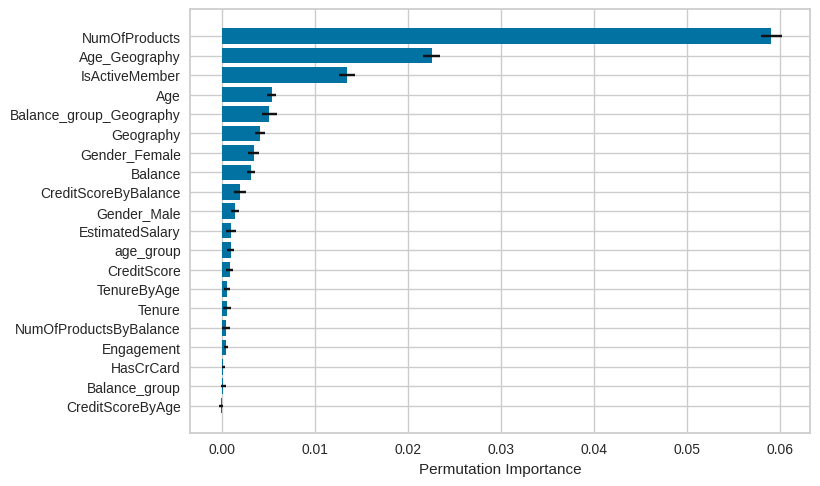

In [ ]:
# puermutation importance
feature_names = train_final_feature.columns


result = permutation_importance(clf_vc, X_valid, y_valid, n_repeats=10, random_state=42, n_jobs=-1)

# 결과 시각화
sorted_idx = result.importances_mean.argsort()
plt.barh(feature_names[sorted_idx], result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx], capsize=5)
plt.xlabel("Permutation Importance")
plt.show()

In [ ]:
# 제출 파일 생성_voting_1
y_valid_preds = clf_vc.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_third_voting_1.csv',index=False)

## 보팅 3개(xgb,cat,gbc) - 0.8907


In [ ]:
# 보팅
clf_vc = VotingClassifier([('CAT', clf_cat), ('XGB', clf_xgb), ('GBC', clf_gbc)], voting='soft')

# 학습
clf_vc.fit(X_train, y_train)

# 검증 데이터 예측
y_valid_preds = clf_vc.predict_proba(X_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

# 검증 데이터 ROC AUC : 0.8907

In [ ]:
# 제출 파일 생성_voting_2
y_valid_preds = clf_vc.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_third_voting_2.csv',index=False)

# 3번째 방법 + Balance_group으로 파생변수 생성

- 파생변수 목록
    - CreditScoreByBalance
    - BalanceByAge
    - NumOfProductsByBalance
    - NumOfProductsByBalance
    - age_group
    - Balance_group
    - Balance_group_Geography
    - Balance_gruop_NumOfProducts
    - Age_geography

- 최종 모델
    - Soft Voting
        - CatBoost, LightGBM, XGBoost,AdaBoost, GBC : 0.8920
        - XGBoost, LightGBM, CatBoost : 0.8920

In [ ]:
# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/테크잇 /9. 파이널 프로젝트 - 12/bank/train.csv')
test = pd.read_csv('/content/drive/MyDrive/테크잇 /9. 파이널 프로젝트 - 12/bank/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/테크잇 /9. 파이널 프로젝트 - 12/bank/sample_submission.csv')

# 변수 제거 : id, CustomerId, Surname
columns_to_drop = ['id', 'CustomerId', 'Surname']
train.drop(columns=columns_to_drop, inplace=True)
test.drop(columns=columns_to_drop, inplace=True)

# 중복 제거(전체 중복)
train = train.drop_duplicates()

# 타입 변경
## float -> int
train[['HasCrCard','IsActiveMember']] = train[['HasCrCard','IsActiveMember']].astype(int)
test[['HasCrCard','IsActiveMember']] = test[['HasCrCard','IsActiveMember']].astype(int)

## Encoding(Object -> int)
train = pd.get_dummies(train, columns=['Gender'],dtype=int)
test = pd.get_dummies(test, columns=['Gender'],dtype=int)

train['Geography'] = train['Geography'].str.replace('France', '1').str.replace('Germany', '2').str.replace('Spain', '3').astype(int)
test['Geography'] = test['Geography'].str.replace('France', '1').str.replace('Germany', '2').str.replace('Spain', '3').astype(int)

## float -> int(소수점 제거)
train['Age'] = (train['Age'] *10).astype(int)
train['Balance'] = round(train['Balance']).astype(int)
train['EstimatedSalary'] = (train['EstimatedSalary']*100).astype(int)

test['Age'] = (test['Age'] *10).astype(int)
test['Balance'] = round(test['Balance']).astype(int)
test['EstimatedSalary'] = (test['EstimatedSalary']*100).astype(int)

# 파생변수 생성

## 연령 별 은행사용기간
train['TenureByAge'] = train.groupby('Age')['Tenure'].transform('mean')
test['TenureByAge'] = test.groupby('Age')['Tenure'].transform('mean')

## 참여도
train['Engagement'] = train['NumOfProducts'] + train['HasCrCard'] + train['IsActiveMember']
test['Engagement'] = test['NumOfProducts'] + test['HasCrCard'] + test['IsActiveMember']

## 잔고 별 신용점수
train['CreditScoreByBalance'] = train.groupby('Balance')['CreditScore'].transform('mean')
test['CreditScoreByBalance'] = test.groupby('Balance')['CreditScore'].transform('mean')

## 연령 별 잔고
train['BalanceByAge'] = train.groupby('Balance')['Age'].transform('mean')
test['BalanceByAge'] = test.groupby('Balance')['Age'].transform('mean')

## 잔고 별 상품 수
train['NumOfProductsByBalance'] = train.groupby('Balance')['NumOfProducts'].transform('mean')
test['NumOfProductsByBalance'] = test.groupby('Balance')['NumOfProducts'].transform('mean')

## age_group
train['age_group'] = pd.cut(train['Age'], bins=[150, 300, 400, 500, 1000],
                         labels=['20', '30', '40','50'],right=False)
test['age_group'] = pd.cut(test['Age'], bins=[150, 300, 400, 500, 1000],
                         labels=['20', '30', '40', '50'],right=False)

### age_gruop type 변경
train['age_group'] = train['age_group'].astype(int)
test['age_group'] = test['age_group'].astype(int)


## Balance_group
train['Balance_group'] = train['Balance'].map(lambda x:0 if x==0 else 1)
test['Balance_group'] = test['Balance'].map(lambda x:0 if x==0 else 1)

## Balance_group + Geography
train['Balance_group_Geography'] = train['Balance_group'] + train['Geography']
test['Balance_group_Geography'] = test['Balance_group'] + test['Geography']

## Balance_group + NumOfProducts
train['Balance_group_NumOfProducts'] = train['Balance_group'] + train['NumOfProducts']
test['Balance_group_NumOfProducts'] = test['Balance_group'] + test['NumOfProducts']

## Age + Geography
train['Age_Geography'] = train['Age'] + train['Geography']
test['Age_Geography'] = test['Age'] + test['Geography']

# 스케일링
## Standard -Balance,TenureByAge,CreditScoreByBalance,Engagement,NumOfProductsByBalance,Balance_group_NumOfProducts','BalanceByAge'
scaler_Standard = StandardScaler()

train[['Balance','TenureByAge','CreditScoreByBalance','Engagement','NumOfProductsByBalance','Balance_group_NumOfProducts','BalanceByAge']] = scaler_Standard.fit_transform(train[['Balance','TenureByAge','Engagement','CreditScoreByBalance','NumOfProductsByBalance','Balance_group_NumOfProducts','BalanceByAge']])
test[['Balance','TenureByAge','CreditScoreByBalance','Engagement','NumOfProductsByBalance','Balance_group_NumOfProducts','BalanceByAge']] = scaler_Standard.fit_transform(test[['Balance','TenureByAge','Engagement','CreditScoreByBalance','NumOfProductsByBalance','Balance_group_NumOfProducts','BalanceByAge']])

## Robust - CreditScore,Age,Age_Geography
scaler_Robust = RobustScaler()
train[['CreditScore','Age','Age_Geography']] = scaler_Robust.fit_transform(train[['CreditScore','Age','Age_Geography']])
test[['CreditScore','Age','Age_Geography']] = scaler_Robust.fit_transform(test[['CreditScore','Age','Age_Geography']])

## MinMax - Tenure,EstimatedSalary
scaler_MinMax = MinMaxScaler()
train[['Tenure','EstimatedSalary']] = scaler_MinMax.fit_transform(train[['Tenure','EstimatedSalary']])
test[['Tenure','EstimatedSalary']] = scaler_MinMax.fit_transform(test[['Tenure','EstimatedSalary']])

# X, Y 분리
train_final_feature = train.loc[:, train.columns != 'Exited']
train_final_target = train['Exited']

# 데이터 분리
X_train, X_valid, y_train,y_valid = train_test_split(train_final_feature, train_final_target,
                                                     test_size=0.17,
                                                     stratify=train_final_target,
                                                     random_state=42)

### lightgbm - 0.8919

In [ ]:
# 하이퍼파라미터 구성
param_bounds_LGB = {
    'n_estimators'      : (50, 500),               # 트리의 개수
    'learning_rate'     : (0.01, 0.3),             # 학습률
    'num_leaves'        : (20, 100),               # 각 트리의 최대 잎의 수
    'max_depth'         : (3, 10),                 # 각 트리의 최대 깊이
    'min_child_samples' : (10, 50),                # 리프 노드가 되기 위한 최소 샘플 수
    'subsample'         : (0.5, 1.0),              # 데이터 샘플링 비율
    'colsample_bytree'  : (0.5, 1.0),              # 트리를 구성할 때 feature를 선택하는 비율
    'reg_alpha'         : (0.0, 1.0),              # L1 regularization term
    'reg_lambda'        : (0.0, 1.0),              # L2 regularization term
    'min_child_weight'  : (0.1, 10.0),             # 각 잎의 최소 가중치 합
}

In [ ]:
def my_func_lgb(n_estimators, learning_rate,num_leaves,max_depth,min_child_samples,subsample,colsample_bytree,reg_alpha,reg_lambda,min_child_weight) :
  model_lgb = LGBMClassifier(
        n_estimators      =int(n_estimators),
        max_depth         =int(max_depth),
        num_leaves        =int(num_leaves),
        learning_rate     =float(learning_rate),
        min_child_samples =int(min_child_samples),
        subsample         =float(subsample),
        colsample_bytree  =float(colsample_bytree),
        reg_alpha         =float(reg_alpha),
        reg_lambda        =float(reg_lambda),
        min_child_weight  =float(min_child_weight),
        random_seed=42
    )

  model_lgb.fit(X_train, y_train)                             # 학습
  y_valid_preds = model_lgb.predict_proba(X_valid)[:, 1]      # 예측 및 평가
  roc_auc = roc_auc_score(y_valid, y_valid_preds)             # 검증 데이터 ROC AUC

  return roc_auc

optimizer_lgb = BayesianOptimization(my_func_lgb, param_bounds_LGB, random_state=42)

In [ ]:
optimizer_lgb.maximize(init_points=10, n_iter=100, acq='ei', xi=0.01)

In [ ]:
optimizer_lgb.max

{'target': 0.8918787381078145,
 'params': {'colsample_bytree': 0.5092328831860857,
  'learning_rate': 0.05328117377074291,
  'max_depth': 7.857145265273323,
  'min_child_samples': 30.36119540487173,
  'min_child_weight': 3.55964379622023,
  'n_estimators': 321.69576006908795,
  'num_leaves': 28.33307791537009,
  'reg_alpha': 0.23140620766748254,
  'reg_lambda': 0.8286631577926487,
  'subsample': 0.5845076743625551}}

In [ ]:
params_lgb= {'colsample_bytree': 0.5092328831860857,
  'learning_rate': 0.05328117377074291,
  'max_depth': 7.857145265273323,
  'min_child_samples': 30.36119540487173,
  'min_child_weight': 3.55964379622023,
  'n_estimators': 321.69576006908795,
  'num_leaves': 28.33307791537009,
  'reg_alpha': 0.23140620766748254,
  'reg_lambda': 0.8286631577926487,
  'subsample': 0.5845076743625551}

def set_model_with_params_lgb(params):
    model = LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        num_leaves=int(params['num_leaves']),
        learning_rate=float(params['learning_rate']),
        min_child_samples=int(params['min_child_samples']),
        subsample=float(params['subsample']),
        colsample_bytree=float(params['colsample_bytree']),
        reg_alpha=float(params['reg_alpha']),
        reg_lambda=float(params['reg_lambda']),
        min_child_weight=float(params['min_child_weight']),
        random_seed=42
    )
    return model



model_lgbm = set_model_with_params_lgb(params_lgb)

In [ ]:
model_lgbm.fit(X_train, y_train)
y_valid_preds = model_lgbm.predict_proba(X_valid)[:,1]

roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')
# 검증 데이터 ROC AUC : 0.8919

[LightGBM] [Info] Number of positive: 28983, number of negative: 107950
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 136933, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211658 -> initscore=-1.314959
[LightGBM] [Info] Start training from score -1.314959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [ ]:
# 제출 파일 생성_LightGBM
y_valid_preds = model_lgbm.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_third2_lightGBM.csv',index=False)

### AdaBoost - 0.8883

In [ ]:
# 하이퍼파라미터 구성
param_bounds_ada = {
    'n_estimators'      :(5, 200),
    'learning_rate'     :(0.01, 1.0),
}


In [ ]:
def my_func_ada(n_estimators, learning_rate):
    model_ada = AdaBoostClassifier(
        n_estimators  = int(n_estimators),
        learning_rate = float(learning_rate),
        random_state  = 42
    )

    model_ada.fit( X_train, y_train)                        # 학습
    y_pred_proba = model_ada.predict_proba(X_valid)[:,1]    # 예측 및 평가
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba) # ROC curve 계산
    roc_auc = roc_auc_score(y_valid, y_pred_proba)          # ROC curve 스코어 계산

    return roc_auc

optimizer_ada = BayesianOptimization(my_func_ada , param_bounds_ada, random_state=42 )

In [ ]:
optimizer_ada.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer_ada.max

{'target': 0.8883417870153054,
 'params': {'learning_rate': 0.8893429095566131,
  'n_estimators': 182.0868459725111}}

In [ ]:
params_ada= {'learning_rate': 0.8893429095566131,
  'n_estimators': 182.0868459725111}

def set_model_with_params_ada(params):
    model = AdaBoostClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=float(params['learning_rate']),
    )
    return model

model_ada = set_model_with_params_ada(params_ada)

In [ ]:
model_ada.fit(X_train, y_train)
y_valid_preds = model_ada.predict_proba(X_valid)[:,1]

roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

# 0.8883

검증 데이터 ROC AUC : 0.8883


In [ ]:
# 제출 파일 생성_AdaBoost
y_valid_preds = model_ada.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_third2_Ada.csv',index=False)

### CatBoost - 0.8914

In [ ]:
# 하이퍼파라미터 구성
param_bounds_cat  = {
    'iterations'          : (50, 500),             # 반복 횟수
    'learning_rate'       : (0.01, 0.3),           # 학습률
    'depth'               : (3, 10),               # 트리의 깊이
    'l2_leaf_reg'         : (0.0, 1.0),            # L2 정규화 계수
    'border_count'        : (32, 255),             # 피쳐의 히스토그램 상자의 수
    'random_strength'     : (0.0, 1.0),            # 랜덤 데이터 샘플을 무시하는 정도
    'bagging_temperature' : (0.0, 1.0),            # 베깅 효과의 온도
    'min_data_in_leaf'    : (1, 50),               # 잎에 필요한 최소 데이터 수
}

In [ ]:
def my_func_cat(iterations,learning_rate,depth,l2_leaf_reg,border_count,random_strength,bagging_temperature,min_data_in_leaf) :
  model = CatBoostClassifier(
      iterations=int(iterations),                     # 부스팅 라운드 수
      learning_rate=float(learning_rate),             # 부스팅의 학습률
      depth=int(depth),                               # 트리의 최대 깊이
      l2_leaf_reg=float(l2_leaf_reg),                 # L2 정규화 계수
      random_strength=float(random_strength),         # 무작위 강도
      bagging_temperature=float(bagging_temperature), # 범주형 데이터를 처리하기 위한 디렉토리에 포함된 개체의 수
      border_count=int(border_count),                 # 범주형 기능의 평균 카디널리티
      min_data_in_leaf=int(min_data_in_leaf)          # 수치 피처에서 사용할 분할 후보를 생성하는 방법
  )

  model_cat.fit(X_train, y_train)                           # 학습
  y_valid_preds = model_cat.predict_proba(X_valid)[:, 1]    # 예측 및 평가
  roc_auc = roc_auc_score(y_valid, y_valid_preds)           # 검증 데이터 ROC AUC

  return roc_auc

optimizer_cat  = BayesianOptimization(my_func_cat, param_bounds_cat, random_state=42)

In [ ]:
optimizer_cat.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer_cat.max

{'target': 0.8914265850040369,
 'params': {'bagging_temperature': 0.575600821152241,
  'border_count': 241.42835370062244,
  'depth': 5.8361448691891615,
  'iterations': 397.15004271752815,
  'l2_leaf_reg': 0.6566140204631591,
  'learning_rate': 0.09695712355884814,
  'min_data_in_leaf': 7.3131400921019445,
  'random_strength': 0.2938114582631196}}

In [ ]:
params_cat= {'bagging_temperature': 0.575600821152241,
  'border_count': 241.42835370062244,
  'depth': 5.8361448691891615,
  'iterations': 397.15004271752815,
  'l2_leaf_reg': 0.6566140204631591,
  'learning_rate': 0.09695712355884814,
  'min_data_in_leaf': 7.3131400921019445,
  'random_strength': 0.2938114582631196}

def set_model_with_params_cat(params):
    model = CatBoostClassifier(
        iterations=int(params['iterations']),                     # 부스팅 라운드 수
        learning_rate=float(params['learning_rate']),             # 부스팅의 학습률
        depth=int(params['depth']),                               # 트리의 최대 깊이
        l2_leaf_reg=float(params['l2_leaf_reg']),                 # L2 정규화 계수
        random_strength=float(params['random_strength']),         # 무작위 강도
        bagging_temperature=float(params['bagging_temperature']), # 범주형 데이터를 처리하기 위한 디렉토리에 포함된 개체의 수
        border_count=int(params['border_count']),                 # 범주형 기능의 평균 카디널리티
        min_data_in_leaf=int(params['min_data_in_leaf'])
    )
    return model


model_cat  = set_model_with_params_cat(params_cat)

In [ ]:
model_cat.fit(X_train, y_train)
y_valid_preds = model_cat.predict_proba(X_valid)[:,1]

roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

# 검증 데이터 ROC AUC : 0.8914

In [ ]:
# 제출 파일 생성_CatBoost
y_valid_preds = model_cat.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_third2_CatBoost.csv',index=False)

### XGBoost - 0.8916

In [ ]:
# 하이퍼파라미터 구성
param_bounds_xgb  = {
    'n_estimators'      : (100,500),
    'learning_rate'     : (0.01, 0.3),
    'max_depth'         : (3, 10),
    'subsample'         : (0.5, 1.0),
    'min_samples_split' : (2,5),
    'min_samples_leaf'  : (2,5),
    'max_leaf_nodes'    : (2,100),
    'colsample_bytree'  : (0.5, 1.0),
}

In [ ]:
def my_func_xgb(n_estimators, learning_rate, max_depth, subsample, min_samples_split, min_samples_leaf, max_leaf_nodes, colsample_bytree):
    model_xgb  = XGBClassifier(
                                n_estimators = int(n_estimators),
                                learning_rate = float(learning_rate),
                                max_depth = int(max_depth),
                                subsample = float(subsample),
                                min_samples_split = int(min_samples_split),
                                min_samples_leaf = int(min_samples_leaf),
                                max_leaf_nodes = int(max_leaf_nodes),
                                colsample_bytree = float(colsample_bytree)
    )

    model_xgb.fit(X_train, y_train)                               # 학습
    y_pred_proba = model_xgb.predict_proba(X_valid)[:, 1]         # 예측 및 평가
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)       # ROC curve 계산
    roc_auc = roc_auc_score(y_valid, y_pred_proba)                # ROC AUC 스코어 계산

    # ROC curve
    return roc_auc

optimizer_xgb  = BayesianOptimization(my_func_xgb, param_bounds_xgb, random_state=42)

In [ ]:
optimizer_xgb.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer_xgb.max

{'target': 0.8915583669615481,
 'params': {'colsample_bytree': 0.6777431100387514,
  'learning_rate': 0.08311906940336561,
  'max_depth': 5.307943963274422,
  'max_leaf_nodes': 94.92344325771356,
  'min_samples_leaf': 3.2399098953260683,
  'min_samples_split': 3.8578701153907096,
  'n_estimators': 177.65317005860285,
  'subsample': 0.7901532360876179}}

In [ ]:
params_xgb= {'colsample_bytree': 0.6777431100387514,
  'learning_rate': 0.08311906940336561,
  'max_depth': 5.307943963274422,
  'max_leaf_nodes': 94.92344325771356,
  'min_samples_leaf': 3.2399098953260683,
  'min_samples_split': 3.8578701153907096,
  'n_estimators': 177.65317005860285,
  'subsample': 0.7901532360876179}


def set_model_with_params_xgb(params):
    model = XGBClassifier(n_estimators = int(params['n_estimators']),
                  learning_rate = float(params['learning_rate']),
                  max_depth = int(params['max_depth']),
                  subsample = float(params['subsample']),
                  min_samples_split = int(params['min_samples_split']),
                  min_samples_leaf = int(params['min_samples_leaf']),
                  max_leaf_nodes = int(params['max_leaf_nodes']),
                  colsample_bytree = float(params['colsample_bytree'])
    )

    return model


model_xgb  = set_model_with_params_xgb(params_xgb)

In [ ]:
model_xgb.fit(X_train, y_train)
y_valid_preds = model_xgb.predict_proba(X_valid)[:,1]

roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

검증 데이터 ROC AUC : 0.8916


In [ ]:
# 제출 파일 생성_XGBoost
y_valid_preds = model_cat.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_third2_XGBoost.csv',index=False)

### gbc - 0.8909

In [ ]:
param_bounds_gbc  = {
    'learning_rate': (0.01, 0.3),                 # 학습률
    'n_estimators': (50, 500),                    # 트리 개수
    'max_depth': (3, 10),                         # 트리 최대 깊이
    'min_samples_split': (2, 20),                 # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': (1, 10)                   # 리프 노드에 필요한 최소 샘플 수
}

In [ ]:
def my_func_gbc(learning_rate, n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features,subsample):
    model_gbc = GradientBoostingClassifier(learning_rate=float(learning_rate),
                                        n_estimators = int(n_estimators),
                                        max_depth = int(max_depth),
                                        min_samples_split = int(min_samples_split),
                                        min_samples_leaf = int(min_samples_leaf),
                                        max_features = float(max_features),
                                        subsample = float(subsample)
    )

    model_gbc.fit(X_train, y_train)                             # 학습
    y_pred_proba = model_gbc.predict_proba(X_valid)[:, 1]       # 예측 및 평가
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)     # ROC curve 계산
    roc_auc = roc_auc_score(y_valid, y_pred_proba)              # ROC AUC 스코어 계산

    return roc_auc

optimizer_gbc = BayesianOptimization(my_func_gbc, param_bounds_gbc, random_state=42)

In [ ]:
optimizer_gbc.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer_gbc.max

{'target': 0.890890299141272,
 'params': {'learning_rate': 0.13710986628871838,
  'max_depth': 5.086647804783424,
  'max_leaves': 84.21507389786609,
  'min_samples_leaf': 3.362510376473673,
  'min_samples_split': 2.121397302245233,
  'n_estimators': 97.56541532484299}}

In [ ]:
params_gbc=  {'learning_rate':0.13710986628871838,
  'max_depth': 5.086647804783424,
  'max_leaves' : 84.21507389786609,
  'min_samples_leaf': 3.362510376473673,
  'min_samples_split': 2.121397302245233,
  'n_estimators': 97.56541532484299}


def set_model_with_params_gbc(params):
    model = GradientBoostingClassifier(learning_rate=float(params['learning_rate']),
                                        n_estimators = int(params['n_estimators']),
                                        max_depth = int(params['max_depth']),
                                        min_samples_split = int(params['min_samples_split']),
                                        min_samples_leaf = int(params['min_samples_leaf'])


)

    return model


model_gbc  = set_model_with_params_gbc(params_gbc)

In [ ]:
model_gbc.fit(X_train, y_train)
y_valid_preds = model_gbc.predict_proba(X_valid)[:, 1]

roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

# 검증 데이터 ROC AUC : 0.8909

검증 데이터 ROC AUC : 0.8909


In [ ]:
# 제출 파일 생성_GBC
y_valid_preds = model_cat.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_third2_GBC.csv',index=False)

## 보팅(cat, lgbm, xgb, gbc, ada) - 0.8920

In [ ]:
# 모델 생성
clf_cat = model_cat
clf_lgb = model_lgbm
clf_xgb = model_xgb
clf_ada = model_ada
clf_gbc = model_gbc

# 보팅
clf_vc = VotingClassifier([('CAT', clf_cat), ('XGB', clf_xgb), ('LGB', clf_lgb), ('ADA', clf_ada), ('GBC', clf_gbc)], voting='soft')

# 학습
clf_vc.fit(X_train, y_train)

# 검증 데이터 예측
y_valid_preds = clf_vc.predict_proba(X_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

# 검증 데이터 ROC AUC : 0.8920

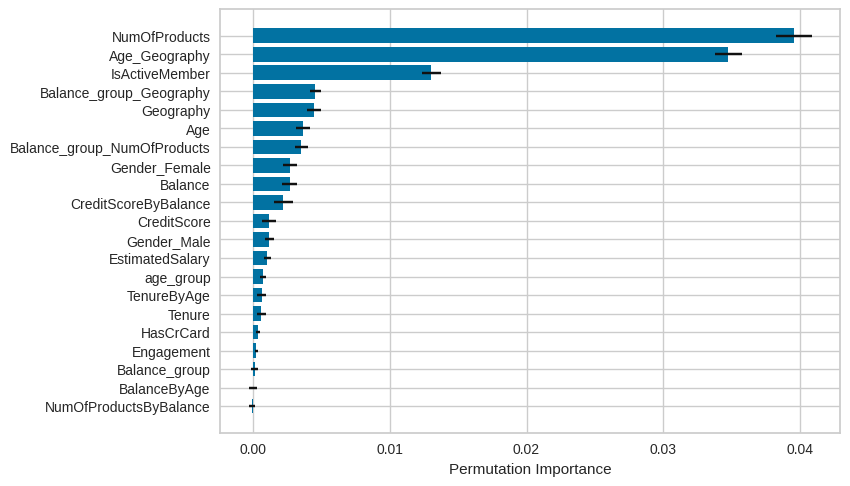

In [ ]:
feature_names = train_final_feature.columns

result = permutation_importance(clf_vc, X_valid, y_valid, n_repeats=10, random_state=42, n_jobs=-1)

# 결과 시각화
sorted_idx = result.importances_mean.argsort()
plt.barh(feature_names[sorted_idx], result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx], capsize=5)
plt.xlabel("Permutation Importance")
plt.show()

In [ ]:
# 제출 파일 생성_voting_1
y_valid_preds = clf_vc.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_third2_voting_1.csv',index=False)

## 보팅 3개(xgb,lgb,cat) - 0.8920

In [ ]:
# 보팅
clf_vc = VotingClassifier([('LGB', clf_lgb), ('CAT', clf_cat), ('XGB', clf_xgb)], voting='soft')

# 학습
clf_vc.fit(X_train, y_train)

# 검증 데이터 예측
y_valid_preds = clf_vc.predict_proba(X_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

# 검증 데이터 ROC AUC : 0.8920

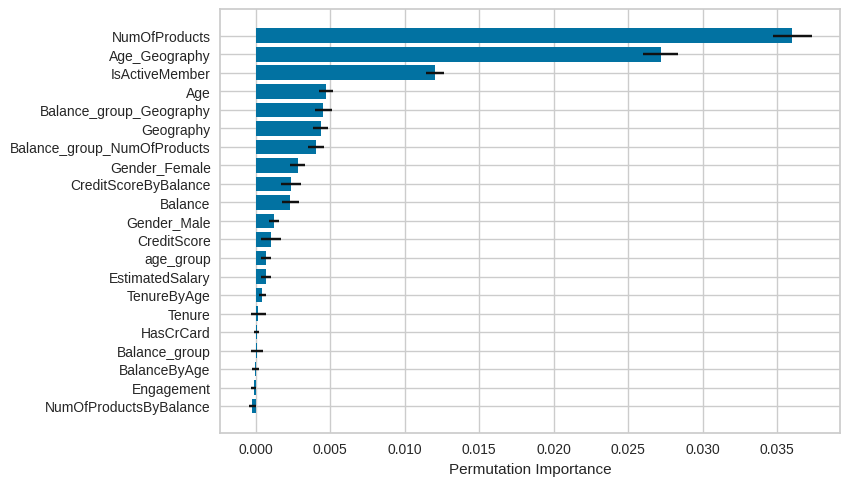

In [ ]:
feature_names = train_final_feature.columns

result = permutation_importance(clf_vc, X_valid, y_valid, n_repeats=10, random_state=42, n_jobs=-1)

# 결과 시각화
sorted_idx = result.importances_mean.argsort()
plt.barh(feature_names[sorted_idx], result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx], capsize=5)
plt.xlabel("Permutation Importance")
plt.show()

In [ ]:
# 제출 파일 생성_voting_2
y_valid_preds = clf_vc.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_third2_voting_2.csv',index=False)